# Udacity DRL Project 2: Continuous Control

---
This notebook provides an outline of a solution to meet the task objectives of the Udacity Deep Reinforcement Learning Nanodegree Project 2. The task set was to solve the 'Reacher' Unity Environment which is an environment with a double jointed arm that is rewarded at each timestep that the agent's 'hand' is within the goal location. The environment is considered solved once the average score across 100 episodes is >= 30.

For this project I have solved the distributed training (20 identical agents) version of the environment.

## 1. Start the Environment

We begin by importing the necessary packages.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%html
<style>
    table {
        display: inline-block
    }
</style>

Next, we will start the environment, which has 20 identical agents in order to distribute the task of gathering experience.

In [3]:
env = UnityEnvironment(file_name='Reacher_Windows_x86_64_20/Reacher.exe')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


The Unity environment contains **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Overview of Environment

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of the agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

The code below provides information on the number of agents as well as the action and state space sizes.

In [5]:
#
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

#print(len(env_info.ps))

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 3. Overview of Solution

### 3.1 Algorithm

The actor critic algorithm selected to complete this task was Proximal Policy Optimization (PPO) with a clipped objective. This is an on-policy algorithm. In addition Generalized Advantage Estimation (GAE) has been imlemented. The implementation of the alogrithm has been based a PPO implementation by Phil Tabor (https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning/PolicyGradient/PPO/torch) but has been adapted for both a continuous environment as well as the use of multiple agents.


### 3.2 Network Design

Separate networks have been produced for both the actor and critic, with no shared elements. This architecture showed similar or better performance than some other alternatives with a shared input layer(s). An overview of the architecture is given below. The actor policy generates actions stochastically from a normal distribution.

Actor

    s -> Linear(s, 256) -> ReLU -> Linear(256, 256) -> ReLU -> Linear(256, a) -> Tanh -> Normal Distribution,
        where s and a is the state and action space sizes respectively.

Critic

    s -> Linear(s, 256) -> ReLU -> Linear(256, 256) -> ReLU -> Linear(256, 1) -> V(s)

The logic for the actor and critic networks is implemented as class `ActorNetwork` and `CriticNetwork` within `ppo.py`.

### 3.3 Hyperparameters

Agent hyperparameters are passed to the constructor class `Agent` in `ppo.py`. The hyperparameter values have been selected by a limited optimization process of varying the values and determining the best values for stability and performance.

| parameter                | value      | description                                                                   |
|--------------------------|------------|-------------------------------------------------------------------------------|
| optimizer_learning_rate  | 1e-3       | Learning rate for Adam optimizer                                              |
| gamma                    | 0.99       | Discount rate for future rewards                                              |
| gae_lambda               | 0.9        | Smoothing parameter for GAE                                                   |
| n_epochs                 | 4          | Number of optimization steps to perform after trajectory rollback             |
| batch_size               | 256        | Number of N-agent experiences to collect for a single optimization step       |
| policy_clip              | 0.2        | Clipping parameter for the policy loss function                               |
| value_loss_weight        | 1.0        | Weight applied to value loss on total loss function                           |

The training hyperparameters defined below are passed to the training function, `train_agent`, defined within this workbook. 

| parameter                     | value     | description                                           |
|-------------------------------|-----------|-------------------------------------------------------|
| n_episodes                    | 300       | Maximum number of training episodes                   |
| max_t                         | 1000      | Trajectory length, maximum no. of timesteps           |
| N                             | 1000      | Number of timesteps before performing a policy update |

In [6]:
# Import PPO actor critic model
from ppo import Agent

#Set agent hyperparameters
alpha = 1e-3
gamma = 0.99
gae_lambda = 0.9
n_epochs=4
batch_size=256
policy_clip = 0.2
value_loss_weight = 1.0

# Initialize agent
# Agent(n_actions, input_dims, gamma, alpha, gae_lambda, policy_clip, batch_size, n_epochs, value_loss_weight)
agent = Agent(action_size, state_size, gamma, alpha, gae_lambda, policy_clip, batch_size, n_epochs, value_loss_weight)

In [7]:
from collections import deque
import torch
import time


def train_agent_(env, agent, n_episodes=300, max_t=1000, 
    display_every=10, solved_score=30, N=1):
    
    st_time = time.time()
    
    scores = []
    scores_window = deque(maxlen=100)
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    n_steps = 0
    
    for i_episode in range(1, n_episodes + 1):    
        env_info = env.reset(train_mode=True)[brain_name]
        
        n_actors = len(env_info.vector_observations)
        score = np.zeros(n_actors)
        episode_length_list = []
        
        
        for t in range(1, max_t+1):
            states = env_info.vector_observations

            actions, probs, vals = agent.choose_action(states)

            env_info = env.step(actions)[brain_name]
            
            next_states = env_info.vector_observations
            
            rewards = np.array(env_info.rewards)       
            
            dones = env_info.local_done
            
            n_steps += 1
            
            score += np.array(rewards)
            score = np.where(dones, 0, score)

            # Collect experience at timestep
            agent.remember(states, actions, probs, vals, rewards, dones)
            
            # If N timesteps have elapsed, use collected experiences to train agent
            if n_steps % N == 0:
                agent.learn()
            
            states = next_states

        mean_score = score.mean()
        scores_window.append(mean_score)       # save most recent score
        scores.append(mean_score)              # save most recent score
        
        print('\rEpisode {}\tAverage score: {:.2f}'.format(
            i_episode, np.mean(scores_window)), end="")
        
        if i_episode % display_every == 0:
            print('\rEpisode {}\tAverage score: {:.2f}'.format(
                i_episode, np.mean(scores_window)))
            
        if np.mean(scores_window) >= solved_score:
            print('\nEnvironment solved in {:d} episodes!\tAverage score: {:.2f}'.format(
                np.maximum(i_episode, 0), np.mean(scores_window)))

            agent.save_models
                
            break
    
    print('\nRun Time: {:.2f}s'.format(time.time() - st_time))
    
    return scores

In [8]:
scores = train_agent_(env, agent, n_episodes=300, solved_score = 30, N=1000)

Episode 10	Average score: 0.59
Episode 20	Average score: 0.60
Episode 30	Average score: 0.45
Episode 40	Average score: 0.36
Episode 50	Average score: 0.32
Episode 60	Average score: 0.30
Episode 70	Average score: 0.33
Episode 80	Average score: 0.38
Episode 90	Average score: 0.45
Episode 100	Average score: 0.56
Episode 110	Average score: 0.77
Episode 120	Average score: 1.08
Episode 130	Average score: 1.53
Episode 140	Average score: 2.34
Episode 150	Average score: 3.65
Episode 160	Average score: 5.27
Episode 170	Average score: 7.16
Episode 180	Average score: 9.33
Episode 190	Average score: 11.59
Episode 200	Average score: 13.96
Episode 210	Average score: 16.39
Episode 220	Average score: 18.87
Episode 230	Average score: 21.63
Episode 240	Average score: 24.30
Episode 250	Average score: 26.48
Episode 260	Average score: 28.55
Episode 268	Average score: 30.07
Environment solved in 268 episodes!	Average score: 30.07

Run Time: 831.47s


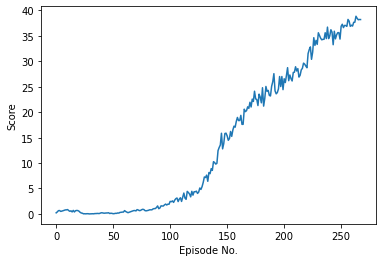

In [9]:
# plot scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode No.')
plt.show()

Watch the trained agent in action.

In [12]:
# load the checkpoint file
agent.load_models

# Run through once with loaded model
env_info = env.reset(train_mode=False)[brain_name]     
states = env_info.vector_observations                  
scores = np.zeros(num_agents)                          
while True:
    actions, _, _ = agent.choose_action(states)                       
    env_info = env.step(actions)[brain_name]           
    next_states = env_info.vector_observations         
    rewards = env_info.rewards                         
    dones = env_info.local_done                        
    scores += env_info.rewards                         
    states = next_states                               
    if np.any(dones):                                  
        break
print('Total score this episode: {:.2f}'.format(scores.mean()))

Total score this episode: 38.78149913316592


In [13]:
env.close()

## 4. Results & Conclusions & Future Work

The selected algorithm was successful in solving the environment within the requirements with a fast timeframe (~10 mins on high end consumer PC with a RTX2080 Ti). The PPO algorithm demonstrated a high level of robustness whilst varying the hyperparameters and the network architectures, with the documented hyperparameters giving the best performance.

Some ideas for future work include:
- Adapting the algorithm to other environments to gauge performance.
- Performance comparison to other algorithms, for example the DDPG benchmark solved in approximately half the number of timesteps.
- Review of further improvements to PPO algorithm to improve performance.